In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2
from sklearn.linear_model import LogisticRegressionCV
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import RandomizedSearchCV

%matplotlib inline

# 1. Exploratory data analysis

### 1.1 Some statistics of the data

In [2]:
df = pd.read_csv('indian_food.csv', na_values=-1)
df.head()

,name,ingredients,diet,prep_time,cook_time,flavor_profile,course,state,region
0,Balu shahi,"Maida flour, yogurt, oil, sugar",vegetarian,45.0,25.0,sweet,dessert,West Bengal,East
1,Boondi,"Gram flour, ghee, sugar",vegetarian,80.0,30.0,sweet,dessert,Rajasthan,West
2,Gajar ka halwa,"Carrots, milk, sugar, ghee, cashews, raisins",vegetarian,15.0,60.0,sweet,dessert,Punjab,North
3,Ghevar,"Flour, ghee, kewra, milk, clarified butter, su...",vegetarian,15.0,30.0,sweet,dessert,Rajasthan,West
4,Gulab jamun,"Milk powder, plain flour, baking powder, ghee,...",vegetarian,15.0,40.0,sweet,dessert,West Bengal,East


In [3]:
df.shape

(255, 9)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255 entries, 0 to 254
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            255 non-null    object 
 1   ingredients     255 non-null    object 
 2   diet            255 non-null    object 
 3   prep_time       225 non-null    float64
 4   cook_time       227 non-null    float64
 5   flavor_profile  226 non-null    object 
 6   course          255 non-null    object 
 7   state           231 non-null    object 
 8   region          241 non-null    object 
dtypes: float64(2), object(7)
memory usage: 18.1+ KB


In [5]:
df.describe()

,prep_time,cook_time
count,225.000000,227.000000
mean,35.386667,38.911894
std,76.241081,49.421711
min,5.000000,2.000000
25%,10.000000,20.000000
50%,10.000000,30.000000
75%,20.000000,45.000000
max,500.000000,720.000000


The continuous features have right-skewed distribution, which we will examine further with some graphs in the next section

### 1.2 Visualizations

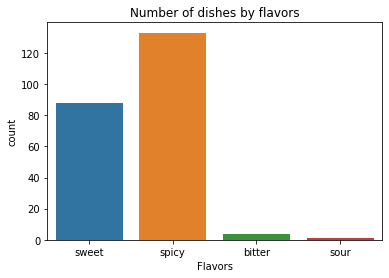

In [6]:
ax = sns.countplot(x = 'flavor_profile', data = df)
ax.set_title("Number of dishes by flavors")
ax.set_xlabel("Flavors")
plt.show()

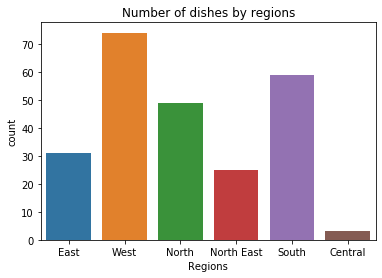

In [7]:
ax = sns.countplot(x = 'region', data = df)
ax.set_title("Number of dishes by regions")
ax.set_xlabel("Regions")
plt.show()

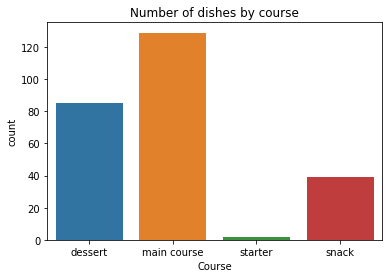

In [8]:
ax = sns.countplot(x = 'course', data = df)
ax.set_title("Number of dishes by course")
ax.set_xlabel("Course")
plt.show()

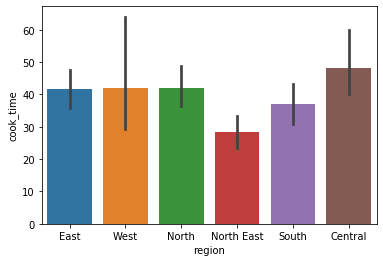

In [9]:
sns.barplot(data=df, x="region", y="cook_time")
plt.show()

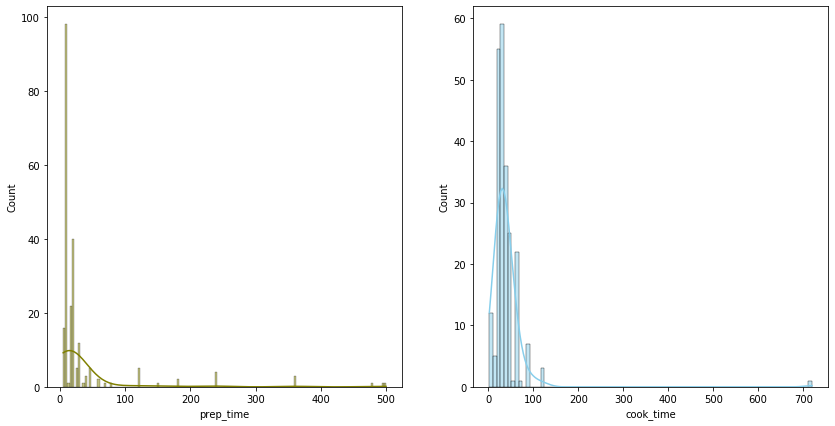

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
sns.histplot(data = df, x = 'prep_time', kde = True, color='olive', ax =ax[0])
sns.histplot(data = df, x = 'cook_time', kde = True, color='skyblue', ax=ax[1])
plt.show()

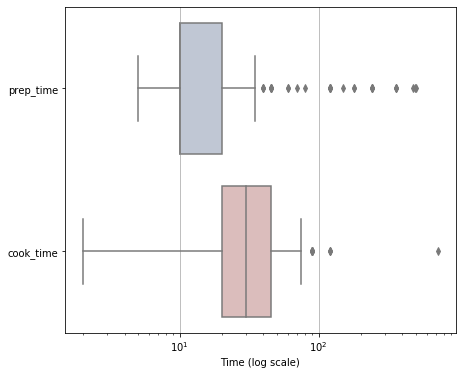

In [11]:
f, ax = plt.subplots(figsize=(7, 6))
ax.set_xscale("log")
sns.boxplot(data = df.loc[:,['prep_time', 'cook_time']], orient='h', palette='vlag')
ax.set_xlabel("Time (log scale)")
ax.xaxis.grid(True)
plt.show()

In [12]:
def draw_boxplots(x_val, xlab):
    fig, ax = plt.subplots(1, 2, figsize=(14, 7), sharey=True)
    ax[0].set_yscale("log")
    sns.boxplot(data = df, x =x_val, y="prep_time", palette='vlag', ax=ax[0])
    sns.boxplot(data = df, x =x_val, y="cook_time", palette='vlag', ax=ax[1])
    ax[0].set_ylabel("Prep time (log scale)")
    ax[0].set_xlabel(xlab)
    ax[0].set_title("Preparation time by " + xlab)
    ax[1].set_ylabel("Cook time (log scale)")
    ax[1].set_xlabel(xlab)
    ax[1].set_title("Cooking time by "+ xlab)
    plt.show()

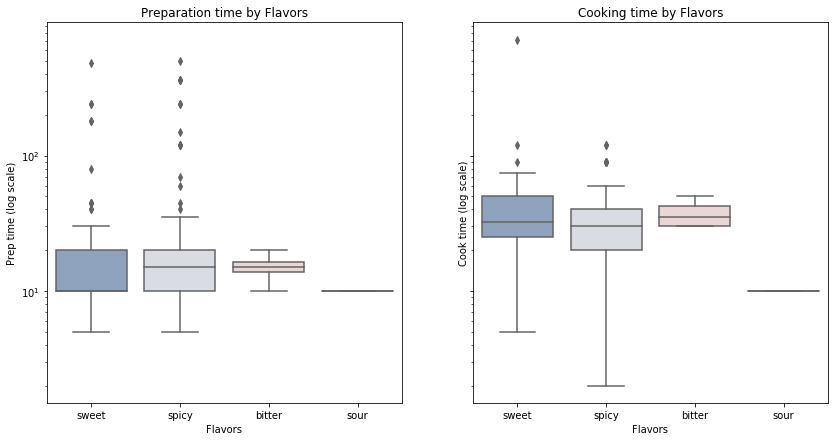

In [13]:
draw_boxplots("flavor_profile", "Flavors")

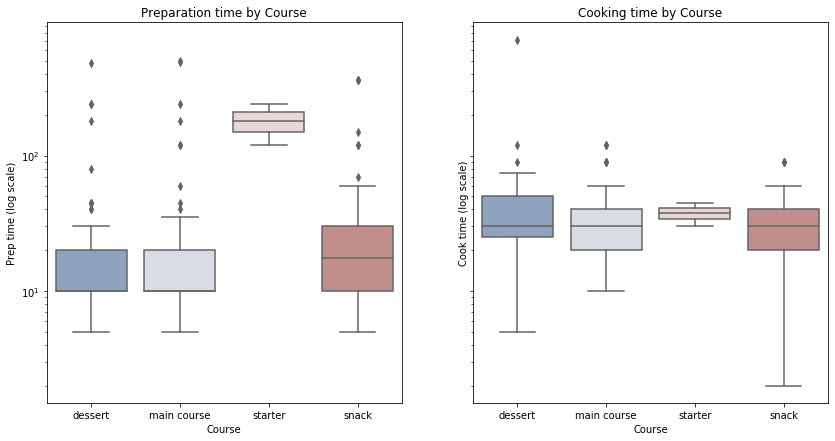

In [14]:
draw_boxplots("course", "Course")

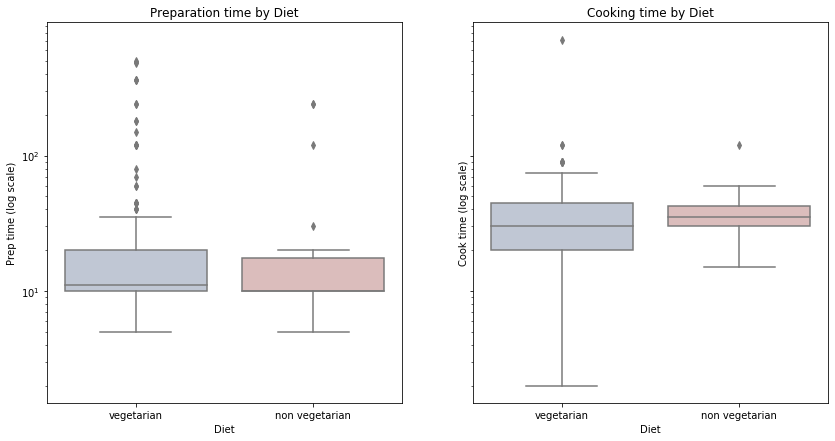

In [15]:
draw_boxplots("diet", "Diet")

In [16]:
df['diet'].value_counts()

vegetarian        226
non vegetarian     29
Name: diet, dtype: int64

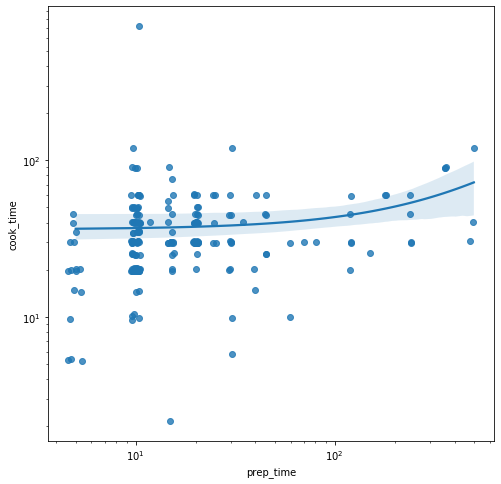

In [17]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.regplot(data=df, x='prep_time', y='cook_time', scatter=True, y_jitter=0.5, x_jitter=0.5)
plt.yscale('log')
plt.xscale('log')
plt.show()

### 1.3 Missing data

In [18]:
df.isnull().mean().round(4)*100

name               0.00
ingredients        0.00
diet               0.00
prep_time         11.76
cook_time         10.98
flavor_profile    11.37
course             0.00
state              9.41
region             5.49
dtype: float64

In [19]:
# since the data is skewed, we use mode to impute the missing data in prep_time
from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df_wo_state_region = df.copy()
df_wo_state_region.drop(['state', 'region'], axis=1, inplace=True)
df_wo_state_region.dropna(subset=['cook_time'], inplace=True)
df_wo_state_region['prep_time'] = imp.fit_transform(df_wo_state_region['prep_time'].values.reshape(-1, 1))
print(df_wo_state_region.isnull().mean().round(4)*100)
print(df_wo_state_region.shape)

name               0.00
ingredients        0.00
diet               0.00
prep_time          0.00
cook_time          0.00
flavor_profile    10.57
course             0.00
dtype: float64
(227, 7)


Around 10% of the data has missing flavor profile. Since our dataset is small, we will proceed to impute them. We will preprocess and encode the categorical variables before using KNN to fill in the missing flavor_profile values.

In [20]:
df_train = df_wo_state_region.copy()

In [21]:
# no duplicates
df_train.duplicated().any()

False

### 1.4 One hot encode categorical data

In [22]:
# preprocess ingredients columns
df_train['is_vegetarian'] = df_train['diet'].map({'vegetarian': 1, 'non vegetarian' : 0}).astype('object')
df_train.head()

,name,ingredients,diet,prep_time,cook_time,flavor_profile,course,is_vegetarian
0,Balu shahi,"Maida flour, yogurt, oil, sugar",vegetarian,45.0,25.0,sweet,dessert,1
1,Boondi,"Gram flour, ghee, sugar",vegetarian,80.0,30.0,sweet,dessert,1
2,Gajar ka halwa,"Carrots, milk, sugar, ghee, cashews, raisins",vegetarian,15.0,60.0,sweet,dessert,1
3,Ghevar,"Flour, ghee, kewra, milk, clarified butter, su...",vegetarian,15.0,30.0,sweet,dessert,1
4,Gulab jamun,"Milk powder, plain flour, baking powder, ghee,...",vegetarian,15.0,40.0,sweet,dessert,1


In [23]:
df_train = df_train.reset_index(drop=True)

In [24]:
# discretize cook_time
bins = [0, 30, 60, 720]
group_names = ['quick', 'medium', 'slow']
df_train['cook_time'] = pd.cut(df_train['cook_time'], bins, labels=group_names)

In [25]:
df_train['cook_time'].value_counts()

quick     131
medium     84
slow       12
Name: cook_time, dtype: int64

In [26]:
# feature encoding for ingredients
# top ingredients by if-idf
from sklearn.feature_extraction.text import TfidfVectorizer

# by flavors
quick_dish = df_train[df_train['cook_time'] == "quick"]['ingredients']
medium_dish = df_train[df_train['cook_time'] == "medium"]['ingredients']
slow_dish = df_train[df_train['cook_time'] == "slow"]['ingredients']

# turn into one document
def one_doc(dishList):
    string = ''
    for dish in dishList:
        string = string + " " + dish
    return string

quick = one_doc(quick_dish)
medium = one_doc(medium_dish)
slow  = one_doc(slow_dish)

In [27]:
vectorizer = TfidfVectorizer()
# vectors = vectorizer.fit_transform([quick, medium, slow])
vectors = vectorizer.fit_transform(df_train['ingredients'])
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
pd.DataFrame(denselist, columns=feature_names)

,acid,all,almond,almonds,aloo,alum,amaranth,amchur,and,anise,...,whipping,white,whole,wild,wine,yam,yellow,yoghurt,yogurt,yolks
0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.531785,0.000000
1,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3,0.0,0.000000,0.0,0.355991,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
4,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
223,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
224,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
225,0.0,0.359378,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.459796


In [31]:
# all_important_ingre = []
# for index, item in enumerate(denselist):
#     scores = {feature: tfidf for feature, tfidf in zip(feature_names, item)}
#     sorted_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)
#     for word, score in sorted_words[:10]:
#         all_important_ingre.append(word)

# # print(set(all_important_ingre))
# top_ingre = list(set(all_important_ingre))
# top_ingre

In [29]:
# zeros = np.zeros((len(df_train), len(top_ingre)))
# dummies = pd.DataFrame(zeros, columns = top_ingre)

In [32]:
# ingredients = df_train['ingredients']
# sep_ingre = ingredients.apply(str.split, sep= ", ")
# for i, dish in enumerate(sep_ingre):
#     dish = list(map(str.lower, dish))
#     indices = dummies.columns.get_indexer(dish)
#     dummies.iloc[i, indices] = 1
# dummies

In [33]:
dummies = pd.DataFrame(denselist, columns=feature_names)

In [34]:
# one hot encoding the flavors
one_hot_encode_data = pd.get_dummies(df_train, columns=['flavor_profile', 'course'])

In [35]:
one_hot_encode_data = one_hot_encode_data.join(dummies.add_prefix('ingre_'))
one_hot_encode_data.drop(['ingredients', 'diet', 'name'], axis=1, inplace=True)

In [36]:
one_hot_encode_data

,prep_time,cook_time,is_vegetarian,flavor_profile_bitter,flavor_profile_sour,flavor_profile_spicy,flavor_profile_sweet,course_dessert,course_main course,course_snack,...,ingre_whipping,ingre_white,ingre_whole,ingre_wild,ingre_wine,ingre_yam,ingre_yellow,ingre_yoghurt,ingre_yogurt,ingre_yolks
0,45.0,quick,1,0,0,0,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.531785,0.000000
1,80.0,quick,1,0,0,0,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,15.0,medium,1,0,0,0,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3,15.0,quick,1,0,0,0,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
4,15.0,medium,1,0,0,0,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,15.0,medium,0,0,0,1,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
223,10.0,quick,1,0,0,1,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
224,5.0,quick,1,0,0,0,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
225,20.0,medium,1,0,0,0,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.459796


In [37]:
one_hot_encode_data['cook_time'] = one_hot_encode_data['cook_time'].map({'quick': 1, 'medium' : 2, 'slow':3})

In [38]:
# use KNN to impute the values for cook time
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)
one_hot_encode_data_full = imputer.fit_transform(one_hot_encode_data)

### 1.5 Train test split

In [39]:
train_info = pd.DataFrame(one_hot_encode_data_full, columns=one_hot_encode_data.columns)
train_info.head()

,prep_time,cook_time,is_vegetarian,flavor_profile_bitter,flavor_profile_sour,flavor_profile_spicy,flavor_profile_sweet,course_dessert,course_main course,course_snack,...,ingre_whipping,ingre_white,ingre_whole,ingre_wild,ingre_wine,ingre_yam,ingre_yellow,ingre_yoghurt,ingre_yogurt,ingre_yolks
0,45.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.531785,0.0
1,80.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,15.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,15.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,15.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [40]:
# ytrain
cook_time = one_hot_encode_data['cook_time']

In [41]:
x_train, x_test, y_train, y_test = train_test_split(train_info.drop('cook_time', axis=1), cook_time, test_size=0.3, 
random_state=8)

In [50]:
x_full = train_info.drop('cook_time', axis=1)

# 2. Baseline model

In [45]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.dummy import DummyClassifier
from numpy import mean
from numpy import std
# evaluate a model
def evaluate_model(X, y, model):
	# define evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
	# evaluate model
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

In [51]:
model = DummyClassifier(strategy='most_frequent')
# evaluate the model
scores = evaluate_model(x_full, cook_time, model)
# summarize performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.577 (0.007)


In [41]:
# def print_base_model_metrics(model, X_train, X_test, Y_train, Y_test):
#     base_pred_train = model.predict(X_train)
#     base_pred_test = model.predict(X_test)
#     print("The training accuracy is {}".format(model.score(X_train, Y_train)))
#     print("The testing accuracy is {}".format(model.score(X_test, Y_test)))
#     print(classification_report(Y_test, base_pred_test))

# def print_base_model_metrics_balanced(model, X_train, X_test, Y_train, Y_test):
#     base_pred_train = model.predict(X_train)
#     base_pred_test = model.predict(X_test)
#     print("The training accuracy is {}".format(balanced_accuracy_score(Y_train, base_pred_train)))
#     print("The testing accuracy is {}".format(balanced_accuracy_score(Y_test, base_pred_test)))
#     print(classification_report_imbalanced(Y_test, base_pred_test))

In [52]:
# base logistic regression model
base_lm = LogisticRegression()
scores = evaluate_model(x_full, cook_time, base_lm)
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
# base_lm.fit(x_train, y_train)
# print_base_model_metrics_balanced(base_lm, x_train, x_test, y_train, y_test)

Mean Accuracy: 0.614 (0.048)


In [53]:
from sklearn.ensemble import RandomForestClassifier

# base random forest model
base_rfc = RandomForestClassifier(random_state=0)
# base_rfc.fit(x_train, y_train)
# print_base_model_metrics_balanced(base_rfc, x_train, x_test, y_train, y_test)
scores = evaluate_model(x_full, cook_time, base_rfc)
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.601 (0.047)


In [55]:
from sklearn.naive_bayes import MultinomialNB
base_clf = MultinomialNB()
# base_clf.fit(x_train, y_train)
# print_base_model_metrics_balanced(base_clf, x_train, x_test, y_train, y_test)
scores = evaluate_model(x_full, cook_time, base_clf)
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.576 (0.048)


In [58]:
from sklearn.svm import SVC
base_svm = SVC(random_state=0)
# base_svm.fit(x_train, y_train)
# print_base_model_metrics_balanced(base_svm, x_train, x_test, y_train, y_test)
scores = evaluate_model(x_full, cook_time, base_svm)
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.583 (0.019)


# 3. Feature engineering

### Initial 

In [59]:
data_improve = train_info.copy()
data_improve = data_improve.reset_index(drop = True)

In [60]:
# standardize 
from sklearn.preprocessing import PowerTransformer
scaler = PowerTransformer(method='box-cox', standardize=False)
data_improve['prep_time'] = scaler.fit_transform(data_improve['prep_time'].values.reshape(-1, 1))
data_improve

,prep_time,cook_time,is_vegetarian,flavor_profile_bitter,flavor_profile_sour,flavor_profile_spicy,flavor_profile_sweet,course_dessert,course_main course,course_snack,...,ingre_whipping,ingre_white,ingre_whole,ingre_wild,ingre_wine,ingre_yam,ingre_yellow,ingre_yoghurt,ingre_yogurt,ingre_yolks
0,1.463390,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.531785,0.000000
1,1.509367,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,1.314016,2.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3,1.314016,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
4,1.314016,2.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,1.314016,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
223,1.227681,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
224,1.019336,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
225,1.363390,2.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.459796


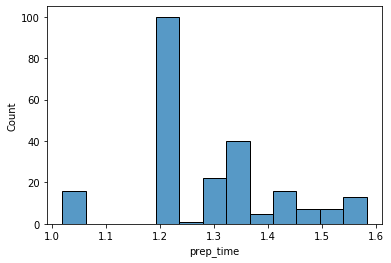

In [61]:
sns.histplot(data=data_improve, x='prep_time')

In [62]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(data_improve.drop('cook_time', axis=1), data_improve['cook_time'],
 test_size=0.15, random_state=0)

In [63]:
x_full2 = data_improve.drop('cook_time', axis=1)
y_full2 = data_improve['cook_time']

In [64]:
lm = LogisticRegression()
scores = evaluate_model(x_full2, y_full2, lm)
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.598 (0.047)


In [65]:
rfc = RandomForestClassifier(random_state=0)
scores = evaluate_model(x_full2, y_full2, rfc)
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.602 (0.047)


In [66]:
clf = MultinomialNB()
scores = evaluate_model(x_full2, y_full2, clf)
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.596 (0.042)


In [67]:
svm = SVC(random_state=0)
scores = evaluate_model(x_full2, y_full2, svm)
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.596 (0.030)


In [68]:
X_resampled, y_resampled = SMOTENC(categorical_features=range(1, 222), random_state=0, 
sampling_strategy='minority').fit_resample(x_full2, y_full2)

In [69]:
lm = LogisticRegression()
scores = evaluate_model(X_resampled, y_resampled, lm)
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

rfc = RandomForestClassifier(random_state=0)
scores = evaluate_model(X_resampled, y_resampled, rfc)
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

clf = MultinomialNB()
scores = evaluate_model(X_resampled, y_resampled, clf)
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

svm = SVC(random_state=0)
scores = evaluate_model(X_resampled, y_resampled, svm)
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.696 (0.041)
Mean Accuracy: 0.710 (0.037)
Mean Accuracy: 0.615 (0.039)
Mean Accuracy: 0.728 (0.023)


# 4. Feature selection

We will use 3 different feature selection methods to select the best subset of features. 

*"Logistic Regression is a good model for testing feature selection methods as it can perform better if irrelevant features are removed from the model"*

### 4.1 Mutual Information model - Logistic Regression

In [86]:
from functools import partial
discrete_feat_idx = range(1, 322)
score_func = partial(mutual_info_classif, discrete_features=discrete_feat_idx, random_state=0)
k_vals = list(np.arange(300, step=10))

In [74]:
import warnings
warnings.filterwarnings("ignore")
def select_features_mutual_info(X_train, Y_train, k_val):
    fs = SelectKBest(score_func=score_func, k=k_val)
    fs.fit(X_train, Y_train)
    X_train_fs = fs.transform(X_train)
    # X_test_fs = fs.transform(X_test)
    return X_train_fs, fs

x_train_fs, fs = select_features_mutual_info(x_full, cook_time, 'all')

<BarContainer object of 322 artists>

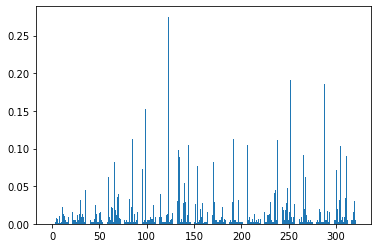

In [75]:
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)

#### Logistic Regression

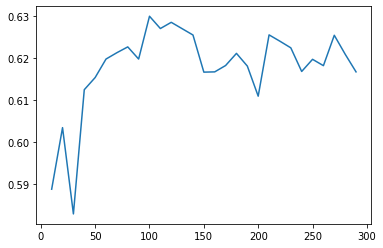

In [87]:
# original
acc = []
for k in k_vals:
    x_train_fs, fs = select_features_mutual_info(x_full, cook_time, k_val=k)
    lr_mutual_info = LogisticRegression()
    scores = evaluate_model(x_train_fs, cook_time, lr_mutual_info)
    acc.append(mean(scores))
plt.plot(k_vals, acc)
plt.show()
# best is k=100

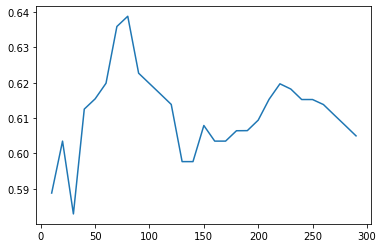

In [91]:
# only
acc = []
for k in k_vals:
    x_train_fs, fs = select_features_mutual_info(x_full2, y_full2, k_val=k)
    lr_mutual_info = LogisticRegression()
    scores = evaluate_model(x_train_fs, y_full2, lr_mutual_info)
    acc.append(mean(scores))
plt.plot(k_vals, acc)
plt.show()
# best k = 80

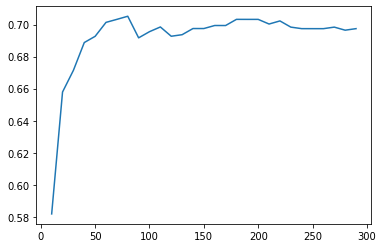

In [94]:
# resampled 
acc = []
for k in k_vals:
    x_train_fs, fs = select_features_mutual_info(X_resampled, y_resampled, k_val=k)
    lr_mutual_info = LogisticRegression()
    scores = evaluate_model(x_train_fs, y_resampled, lr_mutual_info)
    acc.append(mean(scores))
plt.plot(k_vals, acc)
plt.show()
# best k = 80

#### Random Forest

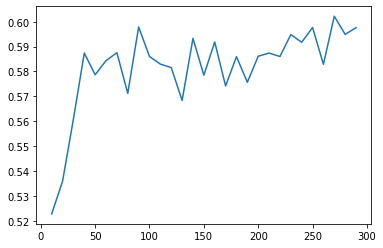

In [98]:
# original
acc = []
for k in k_vals:
    x_train_fs, fs = select_features_mutual_info(x_full, cook_time, k_val=k)
    rfc_mutual_info = RandomForestClassifier(random_state=0)
    scores = evaluate_model(x_train_fs, cook_time, rfc_mutual_info)
    acc.append(mean(scores))
plt.plot(k_vals, acc)
plt.show()

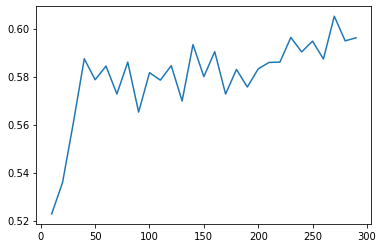

In [101]:
# only
acc = []
for k in k_vals:
    x_train_fs, fs = select_features_mutual_info(x_full2, y_full2, k_val=k)
    rfc_mutual_info = RandomForestClassifier(random_state=0)
    scores = evaluate_model(x_train_fs, y_full2, rfc_mutual_info)
    acc.append(mean(scores))
plt.plot(k_vals, acc)
plt.show()

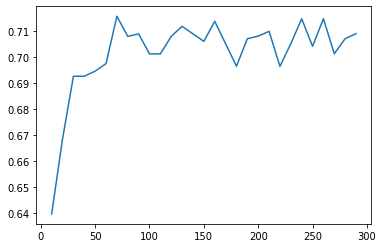

In [103]:
# resampled
acc = []
for k in k_vals:
    x_train_fs, fs = select_features_mutual_info(X_resampled, y_resampled, k_val=k)
    rfc_mutual_info = RandomForestClassifier(random_state=0)
    scores = evaluate_model(x_train_fs, y_resampled, rfc_mutual_info)
    acc.append(mean(scores))
plt.plot(k_vals, acc)
plt.show()
#best k = 70

#### MultiBayes

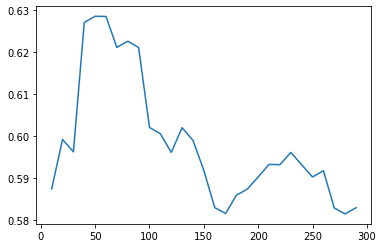

In [106]:
# original
acc = []
for k in k_vals:
    x_train_fs, fs = select_features_mutual_info(x_full, cook_time, k_val=k)
    clf_mutual_info = MultinomialNB()
    scores = evaluate_model(x_train_fs, cook_time, clf_mutual_info)
    acc.append(mean(scores))
plt.plot(k_vals, acc)
plt.show()
#best k = 50

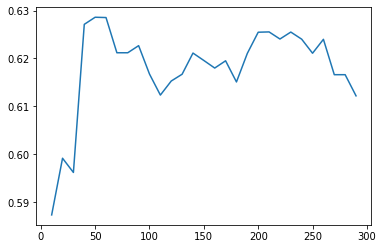

In [110]:
# only
acc = []
for k in k_vals:
    x_train_fs, fs = select_features_mutual_info(x_full2, y_full2, k_val=k)
    clf_mutual_info = MultinomialNB()
    scores = evaluate_model(x_train_fs, y_full2, clf_mutual_info)
    acc.append(mean(scores))
plt.plot(k_vals, acc)
plt.show()
# best k = 50

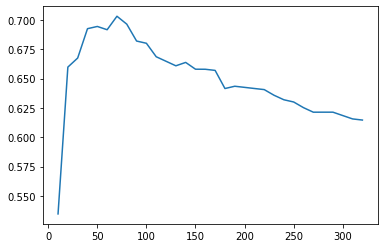

In [116]:
# resampled
k_vals2 = list(np.arange(322, step=10))
acc = []
for k in k_vals2:
    x_train_fs, fs = select_features_mutual_info(X_resampled, y_resampled, k_val=k)
    clf_mutual_info = MultinomialNB()
    scores = evaluate_model(x_train_fs, y_resampled, clf_mutual_info)
    acc.append(mean(scores))
plt.plot(k_vals2, acc)
plt.show()
#best k = 70

#### SVM

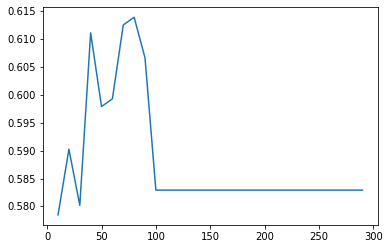

In [119]:
# original
acc = []
for k in k_vals:
    x_train_fs, fs = select_features_mutual_info(x_full, cook_time, k_val=k)
    svm_mutual_info = SVC(random_state=0)
    scores = evaluate_model(x_train_fs, cook_time, svm_mutual_info)
    acc.append(mean(scores))
plt.plot(k_vals, acc)
plt.show()
# best k = 80

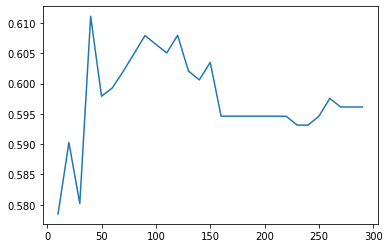

In [122]:
# only
acc = []
for k in k_vals:
    x_train_fs, fs = select_features_mutual_info(x_full2, y_full2, k_val=k)
    svm_mutual_info = SVC(random_state=0)
    scores = evaluate_model(x_train_fs, y_full2, svm_mutual_info)
    acc.append(mean(scores))
plt.plot(k_vals, acc)
plt.show()
#best k = 40

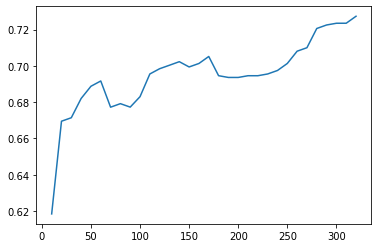

In [128]:
# resampled
acc = []
for k in k_vals2:
    x_train_fs, fs = select_features_mutual_info(X_resampled, y_resampled, k_val=k)
    svm_mutual_info = SVC(random_state=0)
    scores = evaluate_model(x_train_fs, y_resampled, svm_mutual_info)
    acc.append(mean(scores))
plt.plot(k_vals2, acc)
plt.show()
#best k = 320

Transforming the continuous variable - prep_time, help Logistic Regression converges faster, but ended up hurting the performance compared to the baseline model. The best logistic regression model obtained is with 7 features.

### 4.2 Chi-square - Logistic Regression

In [130]:
def select_features_chi2(X_train, Y_train, k_val):
    fs = SelectKBest(score_func=chi2, k=k_val)
    fs.fit(X_train, Y_train)
    X_train_fs = fs.transform(X_train)
    # X_test_fs = fs.transform(X_test)
    return X_train_fs, fs

#### Logistic Regression

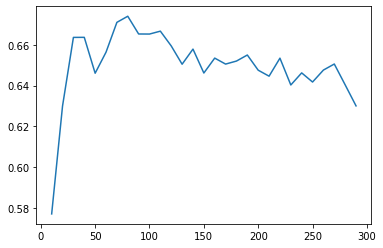

In [131]:
# original
acc = []
for k in k_vals:
    x_train_fs, fs = select_features_chi2(x_full, cook_time, k_val=k)
    lr_mutual_info = LogisticRegression()
    scores = evaluate_model(x_train_fs, cook_time, lr_mutual_info)
    acc.append(mean(scores))
plt.plot(k_vals, acc)
plt.show()
# best is k=80

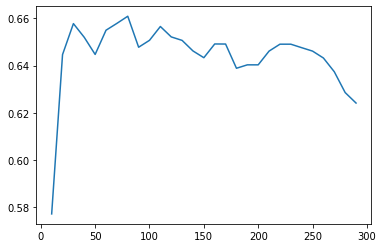

In [133]:
# only
acc = []
for k in k_vals:
    x_train_fs, fs = select_features_chi2(x_full2, y_full2, k_val=k)
    lr_mutual_info = LogisticRegression()
    scores = evaluate_model(x_train_fs, y_full2, lr_mutual_info)
    acc.append(mean(scores))
plt.plot(k_vals, acc)
plt.show()
# best k = 80

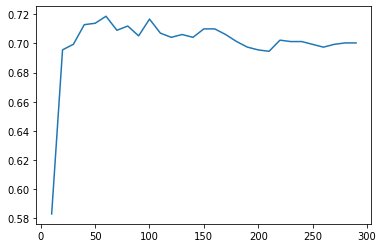

In [136]:
# resampled 
acc = []
for k in k_vals:
    x_train_fs, fs = select_features_chi2(X_resampled, y_resampled, k_val=k)
    lr_mutual_info = LogisticRegression()
    scores = evaluate_model(x_train_fs, y_resampled, lr_mutual_info)
    acc.append(mean(scores))
plt.plot(k_vals, acc)
plt.show()
# best k = 60

#### Random Forest

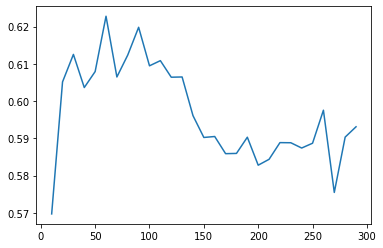

In [138]:
# original
acc = []
for k in k_vals:
    x_train_fs, fs = select_features_chi2(x_full, cook_time, k_val=k)
    rfc_mutual_info = RandomForestClassifier(random_state=0)
    scores = evaluate_model(x_train_fs, cook_time, rfc_mutual_info)
    acc.append(mean(scores))
plt.plot(k_vals, acc)
plt.show()
# best k = 60

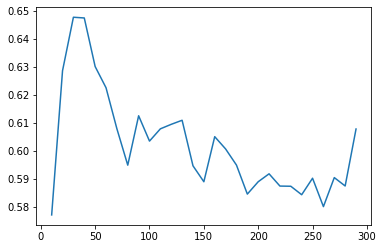

In [140]:
# only
acc = []
for k in k_vals:
    x_train_fs, fs = select_features_chi2(x_full2, y_full2, k_val=k)
    rfc_mutual_info = RandomForestClassifier(random_state=0)
    scores = evaluate_model(x_train_fs, y_full2, rfc_mutual_info)
    acc.append(mean(scores))
plt.plot(k_vals, acc)
plt.show()
# best k = 30

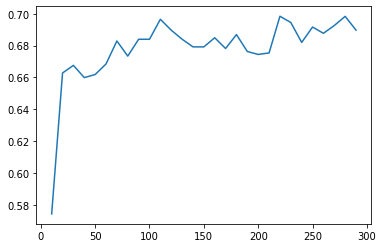

In [142]:
# resampled
acc = []
for k in k_vals:
    x_train_fs, fs = select_features_chi2(X_resampled, y_resampled, k_val=k)
    rfc_mutual_info = RandomForestClassifier(random_state=0)
    scores = evaluate_model(x_train_fs, y_resampled, rfc_mutual_info)
    acc.append(mean(scores))
plt.plot(k_vals, acc)
plt.show()
#best k = 

#### Multiple Bayes

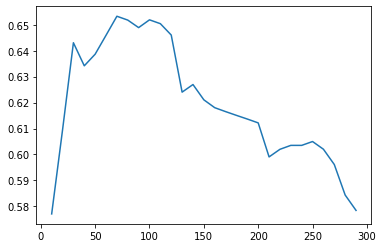

In [145]:
# original
acc = []
for k in k_vals:
    x_train_fs, fs = select_features_chi2(x_full, cook_time, k_val=k)
    clf_mutual_info = MultinomialNB()
    scores = evaluate_model(x_train_fs, cook_time, clf_mutual_info)
    acc.append(mean(scores))
plt.plot(k_vals, acc)
plt.show()
#best k = 70

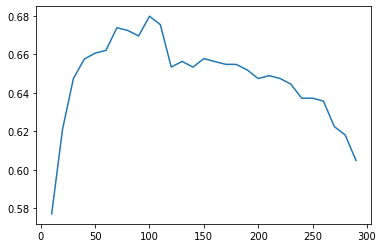

In [148]:
# only
acc = []
for k in k_vals:
    x_train_fs, fs = select_features_chi2(x_full2, y_full2, k_val=k)
    clf_mutual_info = MultinomialNB()
    scores = evaluate_model(x_train_fs, y_full2, clf_mutual_info)
    acc.append(mean(scores))
plt.plot(k_vals, acc)
plt.show()

#best k = 100

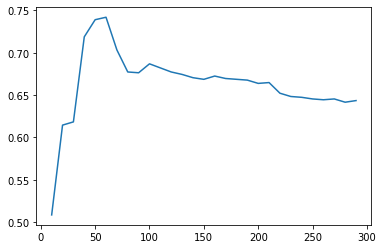

In [151]:
# resampled
acc = []
for k in k_vals:
    x_train_fs, fs = select_features_chi2(X_resampled, y_resampled, k_val=k)
    clf_mutual_info = MultinomialNB()
    scores = evaluate_model(x_train_fs, y_resampled, clf_mutual_info)
    acc.append(mean(scores))
plt.plot(k_vals, acc)
plt.show()
#best k = 60

#### SVM

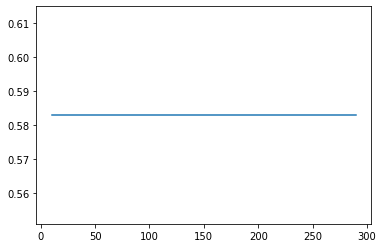

In [156]:
# original
acc = []
for k in k_vals:
    x_train_fs, fs = select_features_chi2(x_full, cook_time, k_val=k)
    svm_mutual_info = SVC(random_state=0)
    scores = evaluate_model(x_train_fs, cook_time, svm_mutual_info)
    acc.append(mean(scores))
plt.plot(k_vals, acc)
plt.show()

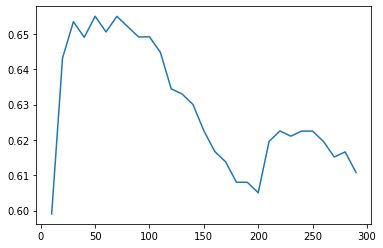

In [154]:
# only
acc = []
for k in k_vals:
    x_train_fs, fs = select_features_chi2(x_full2, y_full2, k_val=k)
    svm_mutual_info = SVC(random_state=0)
    scores = evaluate_model(x_train_fs, y_full2, svm_mutual_info)
    acc.append(mean(scores))
plt.plot(k_vals, acc)
plt.show()
#best k = 40

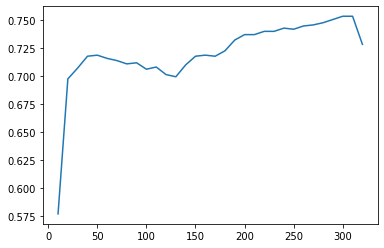

In [158]:
# resampled
acc = []
for k in k_vals2:
    x_train_fs, fs = select_features_chi2(X_resampled, y_resampled, k_val=k)
    svm_mutual_info = SVC(random_state=0)
    scores = evaluate_model(x_train_fs, y_resampled, svm_mutual_info)
    acc.append(mean(scores))
plt.plot(k_vals2, acc)
plt.show()
#best k = 300

# 5. Model tuning

#### 1. RESAMPLED_LR_ONLY

In [174]:
from imblearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
tune_lr = LogisticRegression()

C = [float(x) for x in np.logspace(-3,3,20)]
solver = ['newton-cg', 'sag', 'saga', 'lbfgs']
class_weight = ['balanced', None]

param_grid = {
    'C': C,
    'solver': solver,
    'class_weight': class_weight}
grid_search = RandomizedSearchCV(tune_lr, param_distributions = param_grid, scoring='accuracy',cv=3, n_iter=50,verbose=1, n_jobs=-1)

In [175]:
grid_search.fit(X_resampled, y_resampled)
print("Best parameter (CV score=%0.3f):" % grid_search.best_score_)
print(grid_search.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameter (CV score=0.642):
{'solver': 'sag', 'class_weight': None, 'C': 26.366508987303554}


#### 2. RESAMPLED_RFC_ONLY

In [178]:
tune_rfc = RandomForestClassifier(random_state=0)

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(20, 100, num = 5)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

grid_search = RandomizedSearchCV(tune_rfc, param_distributions = random_grid, scoring='accuracy',cv=3, n_iter=50,verbose=1, n_jobs=-1)

In [179]:
grid_search.fit(X_resampled, y_resampled)
print("Best parameter (CV score=%0.3f):" % grid_search.best_score_)
print(grid_search.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameter (CV score=0.677):
{'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}


#### 3. FS_RESAMPLED_SVM_ONLY chi2

In [180]:
x_train_fs, fs = select_features_chi2(X_resampled, y_resampled, k_val=300)

In [224]:
from sklearn.model_selection import RandomizedSearchCV

# rfcpipe = Pipeline([
#     ('smote', SMOTENC(categorical_features = range(1, 5), k_neighbors = 4, random_state=0)),
#     ('rfc', RandomForestClassifier(verbose = 3, n_jobs = -1))])

C = [float(x) for x in np.logspace(0,3,10)]
gamma = [.0001, .001, .01, .1, 1, 10, 100, "auto"]
degree = [1, 2, 3, 4, 5]
kernel = ['rbf']
random_grid = {'C': C,
              'kernel': kernel,
              'gamma': gamma,
              'degree': degree,
             }

svc = SVC(random_state=8)
random_search = GridSearchCV(estimator=svc,
                                   param_grid=random_grid,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, n_jobs=-1)

In [225]:
random_search.fit(x_train_fs, y_resampled)
print("Best parameter (CV score=%0.3f):" % random_search.best_score_)
print(random_search.best_params_)

Fitting 3 folds for each of 400 candidates, totalling 1200 fits
Best parameter (CV score=0.720):
{'C': 2.154434690031884, 'degree': 1, 'gamma': 1, 'kernel': 'rbf'}
